# Granite TTM — Rolling Forecast (ctx=512, H in {1,3,5,20})


In [1]:
# Install (only if needed)
# pip install -U numpy pandas torch matplotlib
# pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

# source venv312/bin/activate


In [2]:
import os
import sys
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import torch

from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

torch.set_float32_matmul_precision("high")
warnings.filterwarnings("ignore")

PROJECT_ROOT = Path("/Users/jan/Documents/working papers/project 1")
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

DATA_CSV = PROJECT_ROOT / "data/btc_1h_test.csv"
TIMESTAMP_COL = "timestamp"
TARGET_COL = "close"
SERIES_COL = "series"
SERIES_ID = "BTCUSD"

ALLOWED_HORIZONS = (1, 3, 5, 20)
HORIZON = 1  # choose 1, 3, 5, or 20
if HORIZON not in ALLOWED_HORIZONS:
    raise ValueError(f"HORIZON must be one of {ALLOWED_HORIZONS}, got {HORIZON}")

CONTEXT_LENGTH = 512
PREDICTION_LENGTH = max(96, HORIZON)  # model supports up to 96-step outputs
ROLL_STEP = 1
FREQ = "1H"

MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"

OUT_PRED_CSV = PROJECT_ROOT / f"ttm_btc_rolling_pred_h{HORIZON}.csv"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {DEVICE}\nData: {DATA_CSV}")


Device: cpu
Data: /Users/jan/Documents/working papers/project 1/data/btc_1h_test.csv


In [3]:
# data loading and preprocessing
df = pd.read_csv(DATA_CSV, usecols=[TIMESTAMP_COL, TARGET_COL])

df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], utc=True, errors="coerce")
df = df.dropna(subset=[TIMESTAMP_COL, TARGET_COL]).sort_values(TIMESTAMP_COL).reset_index(drop=True)

df[SERIES_COL] = SERIES_ID
df = df[[TIMESTAMP_COL, SERIES_COL, TARGET_COL]].copy()

print(df.head(3))
print(df.tail(3))
print("Rows:", len(df))


                  timestamp  series     close
0 2018-01-01 00:00:00+00:00  BTCUSD  13949.61
1 2018-01-01 01:00:00+00:00  BTCUSD  14111.28
2 2018-01-01 02:00:00+00:00  BTCUSD  13977.47
                     timestamp  series    close
9997 2019-02-21 13:00:00+00:00  BTCUSD  3913.68
9998 2019-02-21 14:00:00+00:00  BTCUSD  3891.74
9999 2019-02-21 15:00:00+00:00  BTCUSD  3898.00
Rows: 10000


In [4]:
# build preprocessor, model, pipeline
column_specifiers = {
    "timestamp_column": TIMESTAMP_COL,
    "id_columns": [SERIES_COL],
    "target_columns": [TARGET_COL],
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    scaling=False,
    encode_categorical=False,
    freq=None,
)

model = get_model(
    model_path=MODEL_PATH,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    freq=None,
).to(DEVICE)

pipe = TimeSeriesForecastingPipeline(
    model=model,
    feature_extractor=tsp,
    device=DEVICE,
    batch_size=32,
)


INFO:p-24499:t-8362287296:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-24499:t-8362287296:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-24499:t-8362287296:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
Device set to use cpu


In [5]:
def _extract_h_step(forecast_df: pd.DataFrame, h_target: int) -> float:
    df = forecast_df.copy()

    for hcol in ("horizon", "step", "k"):
        if hcol in df.columns:
            df = df[df[hcol].astype(int) == h_target]
            break

    if len(df) > 1 and any(c in df.columns for c in ("horizon", "step", "k")):
        df = df.sort_values(by=[c for c in ("horizon", "step", "k") if c in df.columns]).head(1)

    for pcol in ("point", "mean", "yhat", "prediction", "pred"):
        if pcol in df.columns and not df.empty:
            val = df.iloc[0][pcol]
            if isinstance(val, (list, tuple, np.ndarray)):
                return float(val[h_target - 1])
            return float(val)

    for qcol in ("p50", "median", "q50", "q_0.5"):
        if qcol in df.columns and not df.empty:
            val = df.iloc[0][qcol]
            if isinstance(val, (list, tuple, np.ndarray)):
                return float(val[h_target - 1])
            return float(val)

    for col in df.columns:
        val = df.iloc[0][col]
        if isinstance(val, (list, tuple, np.ndarray)) and len(val) >= h_target:
            return float(val[h_target - 1])

    raise ValueError(f"Could not extract horizon {h_target}; seen columns: {list(forecast_df.columns)}")


In [6]:
# rolling forecast
values = df[TARGET_COL].to_numpy(float)
timestamps = df[TIMESTAMP_COL].to_numpy()

min_len = CONTEXT_LENGTH + HORIZON
if len(values) < min_len:
    raise ValueError(f"Need at least {min_len} points, have {len(values)}.")

y_true, y_pred, t_stamps = [], [], []

start = CONTEXT_LENGTH
stop = len(values) - HORIZON + 1

for i in range(start, stop, ROLL_STEP):
    ctx_df = df.iloc[i - CONTEXT_LENGTH : i].copy()
    forecast_df = pipe(ctx_df)

    pred_i = _extract_h_step(forecast_df, h_target=HORIZON)

    y_true.append(values[i + HORIZON - 1])
    y_pred.append(pred_i)
    t_stamps.append(timestamps[i + HORIZON - 1])

    if (i - start) % 200 == 0:
        print(f"Processed i={i}/{stop-1}")

pred_df = pd.DataFrame({
    "timestamp": pd.to_datetime(t_stamps),
    "y_true": np.asarray(y_true, dtype=np.float32),
    "y_pred": np.asarray(y_pred, dtype=np.float32),
})

display(pred_df.head())


Processed i=512/9999
Processed i=712/9999
Processed i=912/9999
Processed i=1112/9999
Processed i=1312/9999
Processed i=1512/9999
Processed i=1712/9999
Processed i=1912/9999
Processed i=2112/9999
Processed i=2312/9999
Processed i=2512/9999
Processed i=2712/9999
Processed i=2912/9999
Processed i=3112/9999
Processed i=3312/9999
Processed i=3512/9999
Processed i=3712/9999
Processed i=3912/9999
Processed i=4112/9999
Processed i=4312/9999
Processed i=4512/9999
Processed i=4712/9999
Processed i=4912/9999
Processed i=5112/9999
Processed i=5312/9999
Processed i=5512/9999
Processed i=5712/9999
Processed i=5912/9999
Processed i=6112/9999
Processed i=6312/9999
Processed i=6512/9999
Processed i=6712/9999
Processed i=6912/9999
Processed i=7112/9999
Processed i=7312/9999
Processed i=7512/9999
Processed i=7712/9999
Processed i=7912/9999
Processed i=8112/9999
Processed i=8312/9999
Processed i=8512/9999
Processed i=8712/9999
Processed i=8912/9999
Processed i=9112/9999
Processed i=9312/9999
Processed i=9

,timestamp,y_true,y_pred
0,2018-01-22 08:00:00+00:00,11541.580078,11547.020508
1,2018-01-22 09:00:00+00:00,11634.089844,11511.543945
2,2018-01-22 10:00:00+00:00,11473.269531,11631.469727
3,2018-01-22 11:00:00+00:00,11634.030273,11520.032227
4,2018-01-22 12:00:00+00:00,11756.500000,11612.590820


In [7]:
# save predictions
pred_df.to_csv(OUT_PRED_CSV, index=False)
print(f"Saved predictions to: {OUT_PRED_CSV} (rows={len(pred_df)})")


Saved predictions to: /Users/jan/Documents/working papers/project 1/ttm_btc_rolling_pred_h1.csv (rows=9488)


In [8]:
from utils.metrics import evaluate_forecast

results = evaluate_forecast(
    y_true=pred_df["y_true"],
    y_pred=pred_df["y_pred"],
    timestamps=pred_df["timestamp"],
    starting_capital=100_000,
    threshold=0.005,
    fee_rate=0.001,
)

eq_end_no = float(results["equity_no_tc"].iloc[-1])
eq_end_tc = float(results["equity_tc"].iloc[-1])
cum_fee = float(results["cum_fee"].iloc[-1])

print(f"Final equity (no TC): {eq_end_no:,.2f}")
print(f"Final equity (with TC): {eq_end_tc:,.2f}")
print(f"Cum fees: {cum_fee:,.2f}")
print({k: results[k] for k in ("arc", "asd", "mdd", "ir_star", "ir_starstar")})

df_eval = pred_df.copy()
df_eval["equity"] = results["equity_no_tc"].to_numpy(float)
df_eval["equity_tc"] = results["equity_tc"].to_numpy(float)
df_eval["fee"] = results["fee"].to_numpy(float)
df_eval["cum_fee"] = results["cum_fee"].to_numpy(float)

display(df_eval.head(3))
display(df_eval.tail(3))


Final equity (no TC): 379,269.47
Final equity (with TC): 5,137.52
Cum fees: 207,507.84
{'arc': 2.427185335604885, 'asd': 0.6347099724857865, 'mdd': 0.3680614277960951, 'ir_star': 3.824085709728215, 'ir_starstar': 25.21797736950201}


,timestamp,y_true,y_pred,equity,equity_tc,fee,cum_fee
0,2018-01-22 08:00:00+00:00,11541.580078,11547.020508,100000.000000,100000.000000,0.0,0.0
1,2018-01-22 09:00:00+00:00,11634.089844,11511.543945,100000.000000,100000.000000,0.0,0.0
2,2018-01-22 10:00:00+00:00,11473.269531,11631.469727,101382.319671,101280.937352,100.0,100.0


,timestamp,y_true,y_pred,equity,equity_tc,fee,cum_fee
9485,2019-02-21 13:00:00+00:00,3913.679932,3925.491211,378660.378323,5134.40631,0.000000,207502.708838
9486,2019-02-21 14:00:00+00:00,3891.739990,3912.425293,378660.378323,5134.40631,0.000000,207502.708838
9487,2019-02-21 15:00:00+00:00,3898.000000,3875.595215,379269.467747,5137.52253,5.134406,207507.843245


TypeError: plot_price_and_equity_panel() got an unexpected keyword argument 'title'

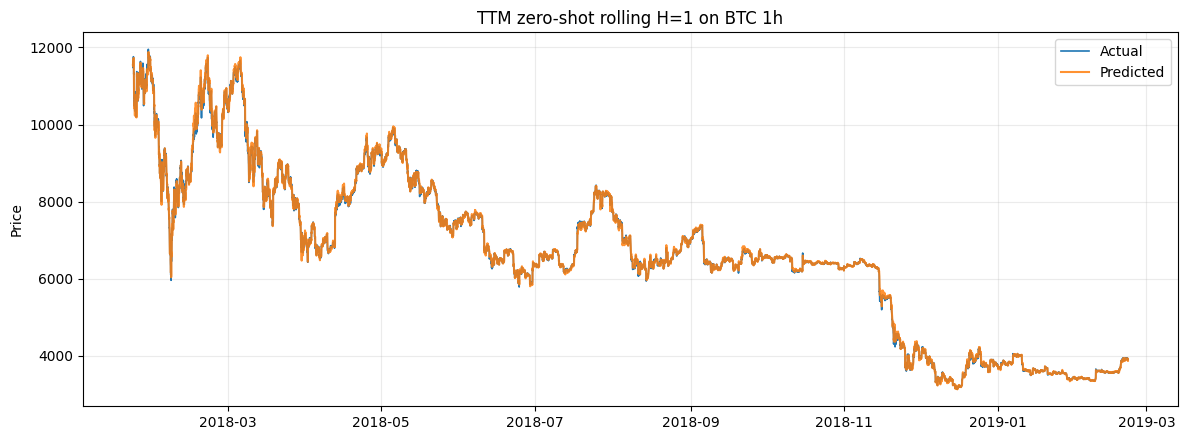

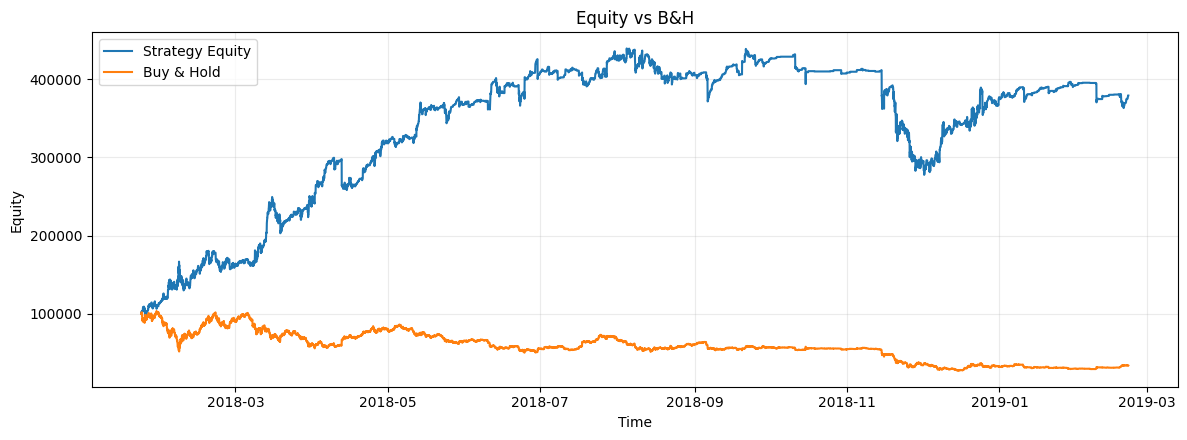

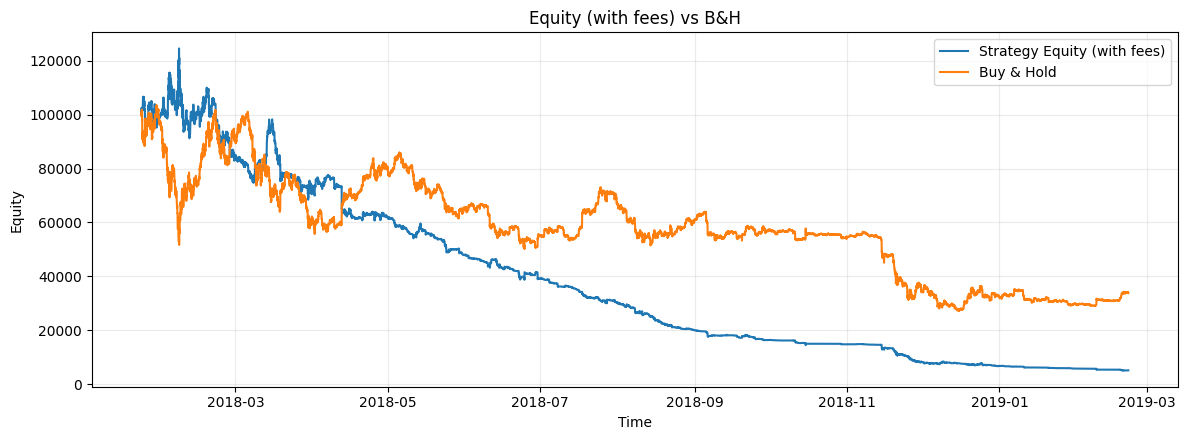

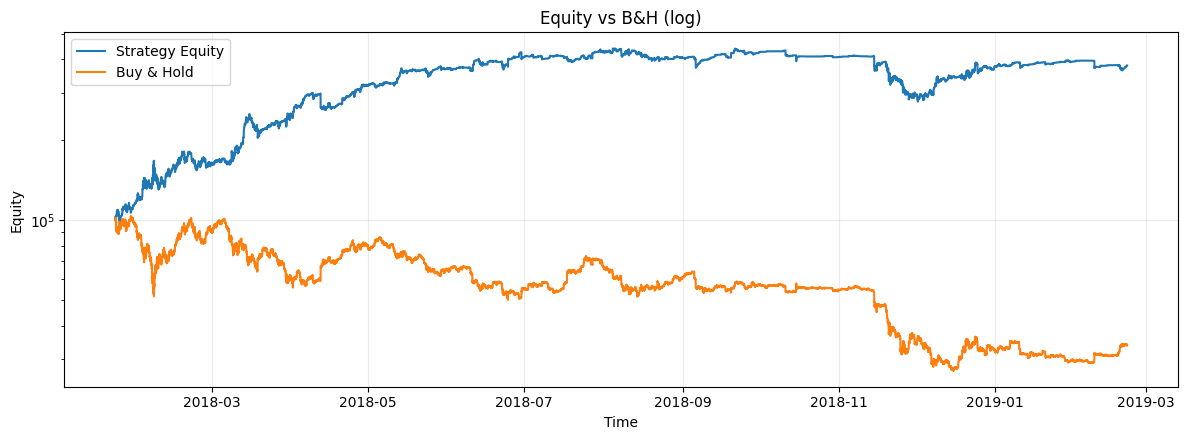

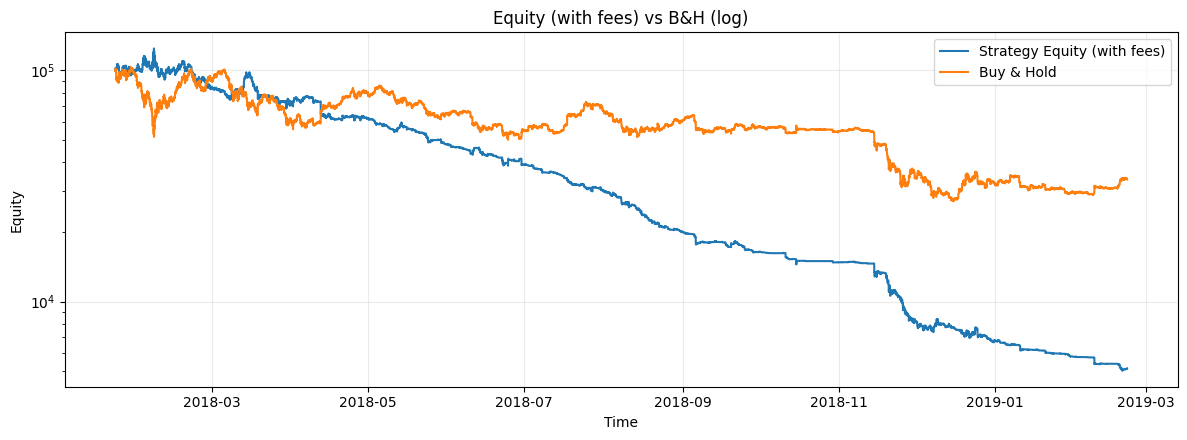

In [9]:
from utils.plotting import (
    plot_price_actual_vs_pred,
    plot_equity_no_tc_vs_bh,
    plot_equity_tc_vs_bh,
    plot_equity_no_tc_vs_bh_log,
    plot_equity_tc_vs_bh_log,
    plot_price_and_equity_panel,
)

plot_price_actual_vs_pred(df_eval, title=f"TTM zero-shot rolling H={HORIZON} on BTC 1h")
plot_equity_no_tc_vs_bh(df_eval, title="Equity vs B&H")
plot_equity_tc_vs_bh(df_eval, title="Equity (with fees) vs B&H")
plot_equity_no_tc_vs_bh_log(df_eval, title="Equity vs B&H (log)")
plot_equity_tc_vs_bh_log(df_eval, title="Equity (with fees) vs B&H (log)")
plot_price_and_equity_panel(df_eval, title=f"TTM rolling H={HORIZON}")
